# Germany Power Generation: Renewable vs Non-Renewable Sources
**Scope:** Analysis of hourly electricity generation by fuel type in Germany (October–December 2022).

### Q4 2022 Germany Power Generation Overview

From the analysis we see that:

* Non-renewable sources of energy  dominated total generation across October, November, and December lignite(brown coal) and gas remained the backbone of supply.
* Renewable energy share was significant but lower in winter months: wind and solar generation dropped reducing the renewable contribution in November and December compared to October.
* December showed the highest overall generation, with non-renewables increasing to compensate for the reduced renewable output.
* The mix shows  Germany’s dependence on fossil fuels for stability in colder month but there is a strong renewable integration.

In [58]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from dotenv import load_dotenv
import requests

load_dotenv()

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (12, 6)

DATA_DIR = Path("./data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path("./figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [59]:
BASE_URL = os.getenv("BASE_URL")
API_KEY = os.getenv("API_KEY")
DATASET  = "task_generation_h"
DATE_FROM = "2022-10-01"
DATE_TO   = "2022-12-31"

In [60]:
RAW_JSON_PATH = DATA_DIR / "raw_generation.json"

CLEAN_HOURLY_WIDE_CSV = DATA_DIR / "germany_hourly_by_fuel_cleaned.csv"
DAILY_CSV = DATA_DIR / "germany_daily_by_fuel_MWh.csv"
MONTHLY_CSV = DATA_DIR / "germany_monthly_by_fuel_MWh.csv"
REN_HOURLY_CSV = DATA_DIR / "germany_hourly_renewable_nonrenewable.csv"
REN_DAILY_CSV  = DATA_DIR / "germany_daily_renewable_nonrenewable.csv"
REN_MONTHLY_CSV= DATA_DIR / "germany_monthly_renewable_nonrenewable.csv"
LONG_FORMAT_CSV= DATA_DIR / "germany_hourly_long.csv"



In [61]:
def load_from_api():
    if not BASE_URL or not API_KEY:
        return None
    
    headers = {"API-Key": API_KEY}
    params = {"dataset": DATASET, "from": DATE_FROM, "to": DATE_TO}
    r = requests.get(BASE_URL, headers=headers, params=params, timeout=60)
    r.raise_for_status()
    payload = r.json()


    df = pd.DataFrame(payload.get("data", []))
    if "columns" in payload and df.shape[1] == len(payload["columns"]):
        df.columns = payload["columns"]
    return df

def load_from_local_file():
    pq = DATA_DIR / "task_generation_h.parquet"
    csv = DATA_DIR / "task_generation_h.csv"
    if pq.exists():
        return pd.read_parquet(pq)
    if csv.exists():
        return pd.read_csv(csv)
    return None


In [62]:
def load_data():
    # local cache
    if RAW_JSON_PATH.exists():
        try:
            obj = json.loads(RAW_JSON_PATH.read_text())
            df = pd.DataFrame(obj.get("data", []))
            if "columns" in obj and df.shape[1] == len(obj["columns"]):
                df.columns = obj["columns"]
            if not df.empty:
                print("Loaded cached API JSON:", RAW_JSON_PATH)
                return df
        except Exception as e:
            print("Cached JSON exists but could not be read:", e)

    # or make API call
    try:
        df_api = load_from_api()
        if df_api is not None and not df_api.empty:
            print("Loaded fresh data from API.")
            # Save cache
            cache_obj = {"columns": list(df_api.columns), "data": df_api.values.tolist()}
            RAW_JSON_PATH.write_text(json.dumps(cache_obj, indent=2))
            print("Saved API cache to", RAW_JSON_PATH)
            return df_api
    except Exception as e:
        print("API fetch failed:", repr(e))

    #  Local manual download
    df_local = load_from_local_file()
    if df_local is not None and not df_local.empty:
        print("Loaded local file from ./data")
        return df_local

    raise FileNotFoundError(
        "No data available. Please download the dataset from the provided link "
        "and place it as './data/task_generation_h.csv' (or .parquet), then run."
    )

df_raw = load_data()
df_raw.head()


Loaded cached API JSON: data/raw_generation.json


,date_id,region,generation,value
0,2022-10-01T00:00:00,France,Non-renewable waste,123.00
1,2022-10-01T00:00:00,France,Run-of-River Hydro,3560.00
2,2022-10-01T00:00:00,Denmark,Run-of-River Hydro,NaN
3,2022-10-01T00:00:00,Germany,Run-of-River Hydro,2085.35
4,2022-10-01T00:00:00,Austria,Run-of-River Hydro,3566.50


In [63]:
# --- Filter for Germany & Pivot ---

expected_cols = {"date_id","region","generation","value"}
missing = expected_cols - set(df_raw.columns)
if missing:
    raise ValueError(f"Input missing expected columns: {missing}")

df_raw["date_id"] = pd.to_datetime(df_raw["date_id"])
df_de = df_raw[df_raw["region"] == "Germany"].copy()
df_de = df_de.sort_values("date_id")

# Pivot: wide by generation (fuel type), incase there are duplicate sum them
dfw = df_de.pivot_table(
    index="date_id",
    columns="generation",
    values="value",
    aggfunc="sum" 
).sort_index()

# using hourly frequency to get a  full range with gaps visible
full_range = pd.date_range(dfw.index.min(), dfw.index.max(), freq="h")
dfw = dfw.reindex(full_range) 
dfw.index.name = "date_id"

print("Wide hourly table (Germany) – shape:", dfw.shape)
# dfw.head()
dfw.isna().sum()

Wide hourly table (Germany) – shape: (2208, 16)


generation
Biomass                      0
Dam Hydro                    0
Geothermal                   0
Hard Coal                    0
Lignite                      0
Natural Gas                  0
Non-renewable waste          0
Nuclear                      0
Oil                          0
Other fossil fuel            0
Other renewables             0
Pumped storage generation    0
Run-of-River Hydro           0
Solar                        0
Wind offshore                0
Wind onshore                 0
dtype: int64

In [64]:
## Outlier treatment using
# Replacement strategy: Replace each outlier by the median for the same month and same hour of the day  for that fuel. If that median is unavailable, 
# fall back to the overall median for that fuel.
def month_hour_medians(s: pd.Series) -> pd.Series:
    month = s.index.to_period("M")
    hour  = s.index.hour
    key = pd.MultiIndex.from_arrays([month, hour], names=["month","hour"])
    med = s.groupby(key).transform("median")
    return med

def replace_outliers_iqr(df):
    df = df.copy()
    for col in df.columns:
        s = df[col]
        q1, q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3 - q1
        if pd.isna(iqr) or iqr == 0:
            continue
        fence_low  = q1 - 1.5 * iqr
        fence_high = q3 + 1.5 * iqr
        mask = (s < fence_low) | (s > fence_high)
        if mask.any():
            mh_med = month_hour_medians(s)
            fallback = s.median()
            repl = mh_med.where(~mh_med.isna(), other=fallback)
            df.loc[mask, col] = repl[mask]
    return df

dfw_no_outliers = replace_outliers_iqr(dfw)
dfw_no_outliers.head()


generation,Biomass,Dam Hydro,Geothermal,Hard Coal,Lignite,Natural Gas,Non-renewable waste,Nuclear,Oil,Other fossil fuel,Other renewables,Pumped storage generation,Run-of-River Hydro,Solar,Wind offshore,Wind onshore
date_id,,,,,,,,,,,,,,,,
2022-10-01 00:00:00,4627.81,74.94,20.81,3206.20,12188.09,5083.37,1204.76,3996.37,30.78,570.09,305.75,71.00,2085.35,0.00,4708.63,23117.49
2022-10-01 01:00:00,4627.81,90.00,20.81,3212.39,12105.32,5072.52,1198.99,4000.12,30.78,570.09,305.75,78.75,2094.58,0.00,4258.34,24271.90
2022-10-01 02:00:00,4612.07,74.26,20.81,3025.96,12281.62,5073.37,1219.75,4000.37,30.78,570.09,305.75,192.00,2075.42,0.00,4464.79,24362.04
2022-10-01 03:00:00,4589.12,70.84,20.81,2813.34,12744.30,5078.26,1218.60,4006.61,30.78,570.09,308.14,153.50,2063.10,0.00,4734.66,26323.79
2022-10-01 04:00:00,4570.55,124.22,20.81,2382.86,12881.97,5078.26,1207.45,4006.36,30.78,570.09,308.93,144.75,2044.62,0.54,4811.73,28200.89


### Impute missing data using linear interpolation since  energy generation normally changes gradually over time base don install capacity or demand, not abruptly.

In [65]:

def impute_missing(df):
    df = df.copy()
    # linear interpolation over time
    df = df.interpolate(method="time", limit_direction="both")
    for col in df.columns:
        s = df[col]
        still_na = s.isna()
        if still_na.any():
            mh_med = month_hour_medians(s)
            s.loc[still_na] = mh_med.loc[still_na]
            still_na = s.isna()
            if still_na.any():
                s.loc[still_na] = s.median()
        df[col] = s
    return df

dfw_clean = impute_missing(dfw_no_outliers)
print("Any remaining NaNs?", dfw_clean.isna().sum().sum())
dfw_clean.head()


Any remaining NaNs? 0


generation,Biomass,Dam Hydro,Geothermal,Hard Coal,Lignite,Natural Gas,Non-renewable waste,Nuclear,Oil,Other fossil fuel,Other renewables,Pumped storage generation,Run-of-River Hydro,Solar,Wind offshore,Wind onshore
date_id,,,,,,,,,,,,,,,,
2022-10-01 00:00:00,4627.81,74.94,20.81,3206.20,12188.09,5083.37,1204.76,3996.37,30.78,570.09,305.75,71.00,2085.35,0.00,4708.63,23117.49
2022-10-01 01:00:00,4627.81,90.00,20.81,3212.39,12105.32,5072.52,1198.99,4000.12,30.78,570.09,305.75,78.75,2094.58,0.00,4258.34,24271.90
2022-10-01 02:00:00,4612.07,74.26,20.81,3025.96,12281.62,5073.37,1219.75,4000.37,30.78,570.09,305.75,192.00,2075.42,0.00,4464.79,24362.04
2022-10-01 03:00:00,4589.12,70.84,20.81,2813.34,12744.30,5078.26,1218.60,4006.61,30.78,570.09,308.14,153.50,2063.10,0.00,4734.66,26323.79
2022-10-01 04:00:00,4570.55,124.22,20.81,2382.86,12881.97,5078.26,1207.45,4006.36,30.78,570.09,308.93,144.75,2044.62,0.54,4811.73,28200.89


In [66]:
#ggregate Daily & Monthly by Fuel(MWH)

df_daily = dfw_clean.resample("D").sum()
df_monthly = dfw_clean.resample("ME").sum()

print("Daily shape:", df_daily.shape, "Monthly shape:", df_monthly.shape)
df_daily.head()

Daily shape: (92, 16) Monthly shape: (3, 16)


generation,Biomass,Dam Hydro,Geothermal,Hard Coal,Lignite,Natural Gas,Non-renewable waste,Nuclear,Oil,Other fossil fuel,Other renewables,Pumped storage generation,Run-of-River Hydro,Solar,Wind offshore,Wind onshore
date_id,,,,,,,,,,,,,,,,
2022-10-01,111341.26,2642.45,499.44,57079.66,275478.73,121219.80,29811.80,96253.65,738.72,13694.90,7377.75,29876.75,47002.73,100605.41,131186.70,623921.96
2022-10-02,111900.65,3113.68,499.44,70306.15,246817.60,117817.50,30387.66,94214.40,738.72,13809.56,7338.79,28370.25,49139.39,122975.04,145290.34,444714.07
2022-10-03,112915.50,6312.17,499.44,143763.22,262323.79,138108.48,30097.42,96686.39,738.72,13295.99,7340.39,40097.75,46000.43,125339.03,61199.33,278501.40
2022-10-04,113024.56,6284.09,499.44,172671.86,307981.87,140326.76,30514.54,96422.80,854.16,10720.24,7351.51,39747.00,46000.43,122645.53,108323.51,209279.16
2022-10-05,112261.71,4939.64,499.44,98730.48,256739.06,148281.32,30372.31,95046.29,738.72,10949.66,7355.50,32522.00,50595.79,128060.17,129380.23,515989.70


In [67]:
# Renewable vs Non-Renewable
renewable_sources = [
    "Biomass", "Dam Hydro", "Geothermal", "Other renewables",
    "Pumped storage generation", "Run-of-River Hydro",
    "Solar", "Wind offshore", "Wind onshore"
]

non_renewable_sources = [
    "Hard Coal", "Lignite", "Natural Gas", "Non-renewable waste",
    "Nuclear", "Oil", "Other fossil fuel"
]

ren_cols = [c for c in renewable_sources if c in dfw_clean.columns]
nren_cols = [c for c in non_renewable_sources if c in dfw_clean.columns]

hourly_ren = pd.DataFrame({
    "renewable_MWh": dfw_clean[ren_cols].sum(axis=1) if ren_cols else 0.0,
    "non_renewable_MWh": dfw_clean[nren_cols].sum(axis=1) if nren_cols else 0.0,
})
hourly_ren["total_MWh"] = hourly_ren.sum(axis=1)
hourly_ren["renewable_%"] = np.where(hourly_ren["total_MWh"]>0, 100*hourly_ren["renewable_MWh"]/hourly_ren["total_MWh"], np.nan)
hourly_ren["non_renewable_%"] = np.where(hourly_ren["total_MWh"]>0, 100*hourly_ren["non_renewable_MWh"]/hourly_ren["total_MWh"], np.nan)

daily_ren = hourly_ren.resample("D").sum()
daily_ren["renewable_%"] = np.where(daily_ren["total_MWh"]>0, 100*daily_ren["renewable_MWh"]/daily_ren["total_MWh"], np.nan)
daily_ren["non_renewable_%"] = np.where(daily_ren["total_MWh"]>0, 100*daily_ren["non_renewable_MWh"]/daily_ren["total_MWh"], np.nan)

monthly_ren = hourly_ren.resample("ME").sum()
monthly_ren["renewable_%"] = np.where(monthly_ren["total_MWh"]>0, 100*monthly_ren["renewable_MWh"]/monthly_ren["total_MWh"], np.nan)
monthly_ren["non_renewable_%"] = np.where(monthly_ren["total_MWh"]>0, 100*monthly_ren["non_renewable_MWh"]/monthly_ren["total_MWh"], np.nan)

hourly_ren.head()

,renewable_MWh,non_renewable_MWh,total_MWh,renewable_%,non_renewable_%
date_id,,,,,
2022-10-01 00:00:00,35011.78,26279.66,61291.44,57.123442,42.876558
2022-10-01 01:00:00,35747.94,26190.21,61938.15,57.715544,42.284456
2022-10-01 02:00:00,36107.14,26201.94,62309.08,57.948440,42.051560
2022-10-01 03:00:00,38263.96,26461.98,64725.94,59.116886,40.883114
2022-10-01 04:00:00,40227.04,26157.77,66384.81,60.596754,39.403246


In [68]:
##covert back Convert the cleaned hourly wide table back to the original long format
# ['date_id','region','generation','value']

df_long = (
    dfw_clean
      .reset_index()
      .melt(id_vars="date_id", var_name="generation", value_name="value")
      .assign(region="Germany")
      .loc[:, ["date_id","region","generation","value"]]
      .sort_values(["date_id","generation"])
      .reset_index(drop=True)
)
df_long.head()

,date_id,region,generation,value
0,2022-10-01,Germany,Biomass,4627.81
1,2022-10-01,Germany,Dam Hydro,74.94
2,2022-10-01,Germany,Geothermal,20.81
3,2022-10-01,Germany,Hard Coal,3206.20
4,2022-10-01,Germany,Lignite,12188.09


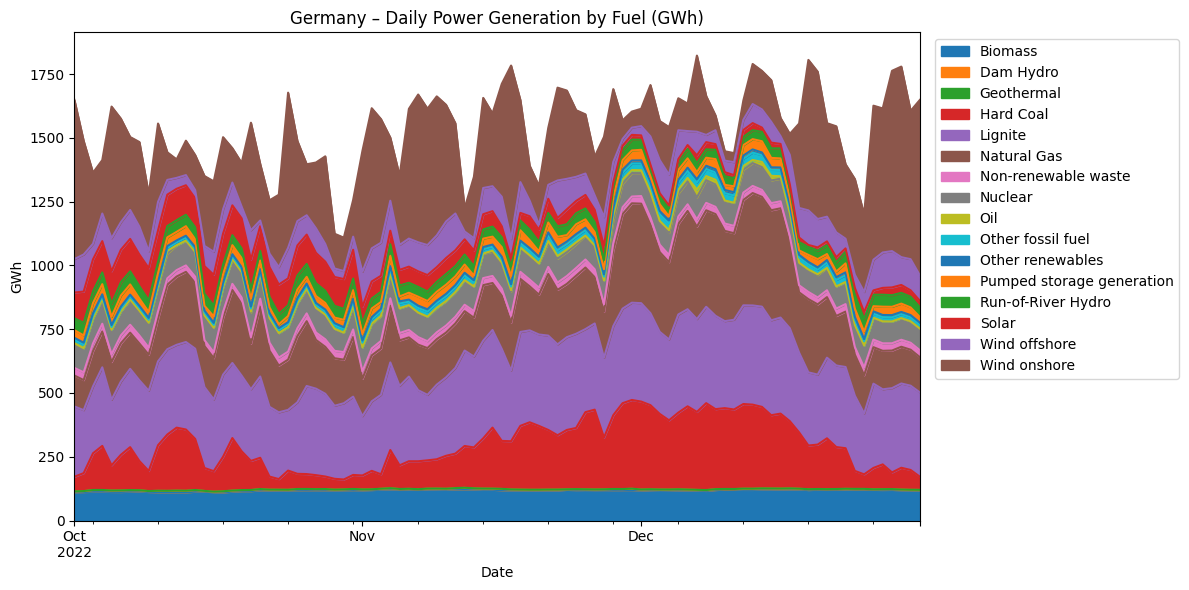

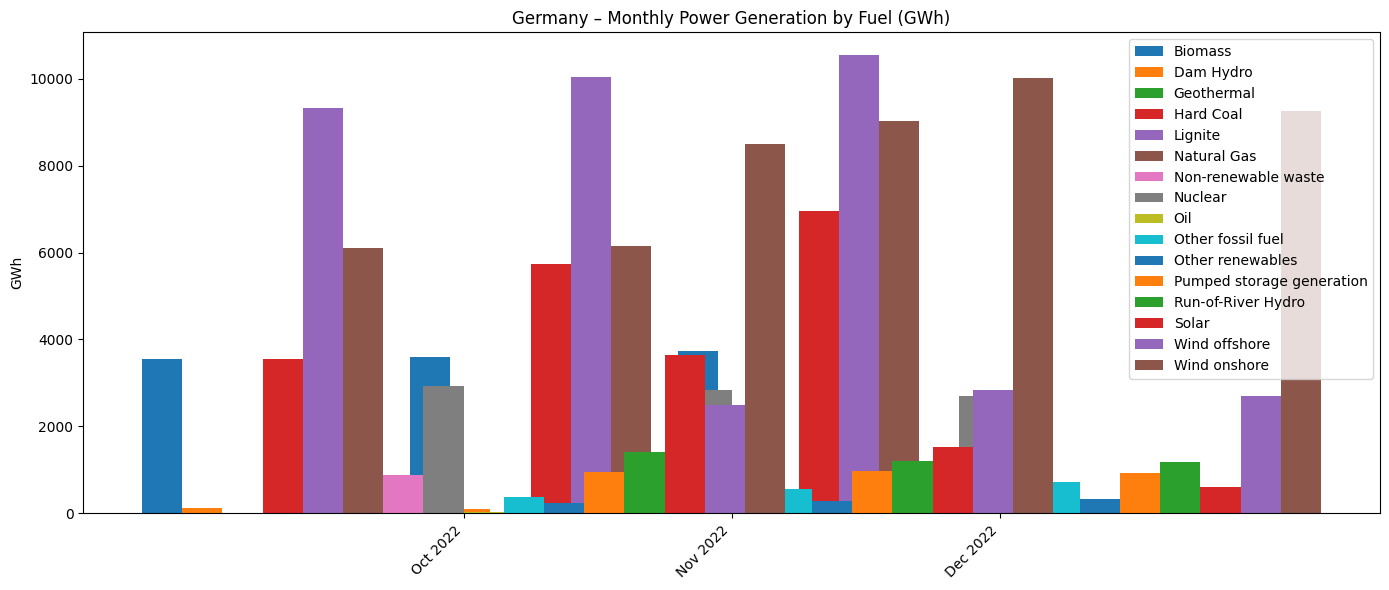

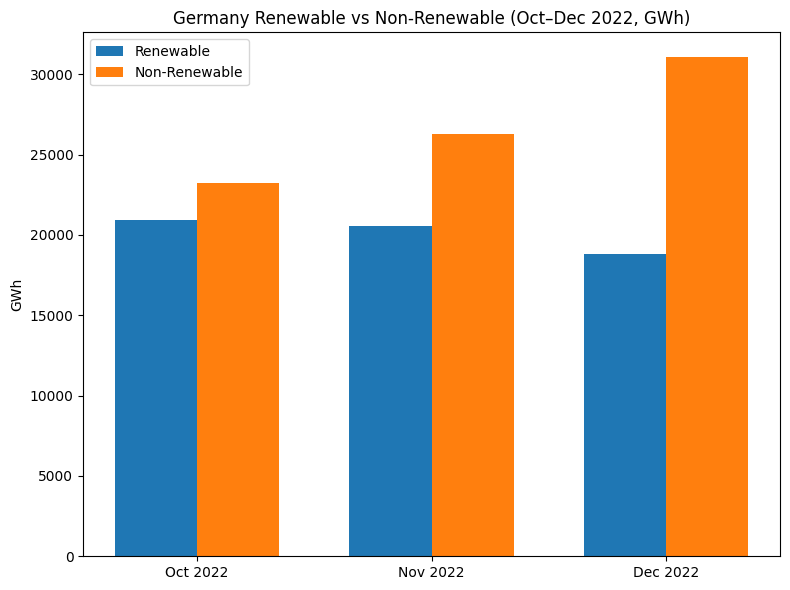

In [69]:
# visualization
#  Stacked area of daily totals by fuel (GWh).

FIG_STACKED_DAILY = FIG_DIR/ "figure_stacked_area_daily_GWh.png"
FIG_BAR_DAILY = FIG_DIR/ "figure_bar_comparison_sources_GWh.png"
FIG_REN_BAR = FIG_DIR/ "figure_renewable_vs_nonrenewable_Oct_Dec_GWh.png"

daily_gwh = df_daily / 1000 
ax = daily_gwh.plot.area()

ax.set_title("Germany – Daily Power Generation by Fuel (GWh)")
ax.set_xlabel("Date")
ax.set_ylabel("GWh")
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

plt.tight_layout()
plt.savefig(FIG_STACKED_DAILY, dpi=150)
plt.show()

#### BAr chart comparing daily generation by Fuel
monthly_gwh = df_monthly / 1000
months = monthly_gwh.index.strftime("%b %Y")
x = np.arange(len(monthly_gwh))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))
for i, col in enumerate(monthly_gwh.columns):
    ax.bar(x + i*width, monthly_gwh[col], width, label=col)

ax.set_xticks(x + width*(len(monthly_gwh.columns)/2 - 0.5))
ax.set_xticklabels(months, rotation=45, ha="right")

ax.set_ylabel("GWh")
ax.set_title("Germany – Monthly Power Generation by Fuel (GWh)")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_BAR_DAILY , dpi=150)
plt.show()

#Bar chart comparing Renewable vs Non-Renewable in Oct to  Dec 2022 (GWh)
oct_mask = (daily_ren.index >= "2022-10-01") & (daily_ren.index <= "2022-10-31")
nov_mask = (daily_ren.index >= "2022-11-01") & (daily_ren.index <= "2022-11-30")
dec_mask = (daily_ren.index >= "2022-12-01") & (daily_ren.index <= "2022-12-31")

oct_totals = daily_ren.loc[oct_mask, ["renewable_MWh","non_renewable_MWh"]].sum()/1000.0
nov_totals = daily_ren.loc[nov_mask, ["renewable_MWh","non_renewable_MWh"]].sum()/1000.0
dec_totals = daily_ren.loc[dec_mask, ["renewable_MWh","non_renewable_MWh"]].sum()/1000.0

renewable_vals = [oct_totals["renewable_MWh"], nov_totals["renewable_MWh"], dec_totals["renewable_MWh"]]
nonrenewable_vals = [oct_totals["non_renewable_MWh"], nov_totals["non_renewable_MWh"], dec_totals["non_renewable_MWh"]]

fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(3) 
width = 0.35

ax.bar(x - width/2, renewable_vals, width, label="Renewable")
ax.bar(x + width/2, nonrenewable_vals, width, label="Non-Renewable")

ax.set_xticks(x)
ax.set_xticklabels(["Oct 2022", "Nov 2022", "Dec 2022"])
ax.set_ylabel("GWh")
ax.set_title("Germany Renewable vs Non-Renewable (Oct–Dec 2022, GWh)")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_REN_BAR, dpi=150)
plt.show()


## Conclusion (Q4 2022 Germany Power Generation)

* Non-renewable sources of energy  dominated total generation across October, November, and December lignite(brown coal) and gas remained the backbone of supply.
* Renewable energy share was significant but lower in winter months: wind and solar generation dropped reducing the renewable contribution in November and December compared to October.
* December showed the highest overall generation, with non-renewables increasing to compensate for the reduced renewable output.
* The mix shows  Germany’s dependence on fossil fuels for stability in colder month but there is a strong renewable integration.

In [70]:

dfw_clean.to_csv(CLEAN_HOURLY_WIDE_CSV, index=True)
df_daily.to_csv(DAILY_CSV, index=True)
df_monthly.to_csv(MONTHLY_CSV, index=True)

hourly_ren.to_csv(REN_HOURLY_CSV, index=True)
daily_ren.to_csv(REN_DAILY_CSV, index=True)
monthly_ren.to_csv(REN_MONTHLY_CSV, index=True)

df_long.to_csv(LONG_FORMAT_CSV, index=False)

print("Saved:")
print(" -", CLEAN_HOURLY_WIDE_CSV)
print(" -", DAILY_CSV)
print(" -", MONTHLY_CSV)
print(" -", REN_HOURLY_CSV)
print(" -", REN_DAILY_CSV)
print(" -", REN_MONTHLY_CSV)
print(" -", LONG_FORMAT_CSV)
print(" -", FIG_STACKED_DAILY)
print(" -", FIG_REN_BAR)

Saved:
 - data/germany_hourly_by_fuel_cleaned.csv
 - data/germany_daily_by_fuel_MWh.csv
 - data/germany_monthly_by_fuel_MWh.csv
 - data/germany_hourly_renewable_nonrenewable.csv
 - data/germany_daily_renewable_nonrenewable.csv
 - data/germany_monthly_renewable_nonrenewable.csv
 - data/germany_hourly_long.csv
 - figures/figure_stacked_area_daily_GWh.png
 - figures/figure_renewable_vs_nonrenewable_Oct_Dec_GWh.png
